MODEL SPECIFICATION:

In [2]:
# Variables
train_size = 4000
shuffle_buffer = 100000
total_epochs = 6000
num_classes = 10

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
import math

Step decay for training.

In [25]:
def step_decay(epoch):
    initial_learning_rate = 0.1
    drop = 0.1
    epochs_drop = 500.0
    lrate = initial_learning_rate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

In [26]:
#Early stopping spec
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
#Learning schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(step_decay)


In [27]:
import utils as tl

## We download the MNIST Data from TF

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [29]:
x_train = x_train[-train_size:]
y_train = y_train[-train_size:]

MNIST data are 28x28 grayscale images. Each pixel can get a value from 0 to 255 thus we divide by 255 to normalise to 1.

In [30]:
#We normalise the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [31]:
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

Number of images in x_train 4000
Number of images in x_test 10000


In [32]:
# Convert to "one-hot" vectors using the to_categorical function
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## We train the Neural Networks according to the paper specifications

In [33]:
parameter_size = [3000, 5000, 10000, 20000, 
                  22000, 25000, 27000, 30000, 32000, 35000, 37000,
                40000, 50000, 60000, 70000, 80000, 100000, 300000, 800000]

We need to compute the number of hidden units $H$ corresponding to each parameter $w$.

$$ H  = \frac{w-K}{d+K+1} $$

where $d=784$ is the dimension of the input layer and $K=10$ that of the output layer. We also recall that the interpolation threshold can be found by 

$$ n\times K = 4\cdot 10^{3} \times 10= 4\cdot 10^{4}$$.

In [34]:
input_size = 784 #28*28
interpol_threshold = num_classes * train_size

Here we use the following empirical risk

$$ \frac{1}{n} \sum_{i=1}^{n}l(h(x_{i}),y_{i})$$

where $l(y',y) = (y'-y)^{2}$ is the squared loss function and $h(x)$ is our fully connected network.

## With Weight Reuse Scheme

In [35]:
import pandas as pd

In [60]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()
for run in range(1,6):
    training_loss = []
    test_loss = []
    training_dict  = {}
    test_dict  = {}
    for parameters in parameter_size:
        train_loss = tf.keras.losses.MeanSquaredError(name = "train_loss")
        sgd_optimizer = tf.keras.optimizers.SGD(momentum=0.95)
        #Gives number of units from number of weights
        units = tl.get_number_units(parameters, input_size = input_size, output_size = num_classes)
        if units == 3000:
            network = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),#We flatten the images to vector of size 784
            tf.keras.layers.Dense(units=units, activation = None),#Hidden Layer
            tf.keras.layers.Dense(units=num_classes, activation = None)#Output Layer
            ])
        elif units < interpol_threshold and units > 3000 :
            network = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(units=units, bias_initializer = tf.constant_initializer(tl.custom_bias(units,hidden_bias_wgts)),
                                kernel_initializer = tf.constant_initializer(tl.custom_kernel(units,hidden_kernel_wgts)),  activation = None),
            tf.keras.layers.Dense(units=num_classes, bias_initializer = tf.constant_initializer(tl.custom_bias(units,hidden_bias_wgts)),
                                kernel_initializer = tf.constant_initializer(tl.custom_kernel(units,hidden_kernel_wgts)),  activation = None)])
        else:
            network = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(units=units, activation = None),
            tf.keras.layers.Dense(units=num_classes,  activation = None)])
            #Training
        network.compile(optimizer = sgd_optimizer, loss = train_loss , metrics = ['accuracy'])
        print("Fitting Parameter:{}, RUN:{}".format(parameters,run))
        if units < interpol_threshold:
            history = network.fit(x=x_train, y=y_train, callbacks=[earlystop_callback,lr_schedule], epochs=total_epochs, verbose = 0)
        else:
            history = network.fit(x=x_train, y=y_train, epochs=total_epochs, verbose = 0)
        if units <= interpol_threshold:
            hidden_kernel_wgts = network.get_weights()[0]
            hidden_bias_wgts = network.get_weights()[1]
            output_kernel_wgts = network.get_weights()[2]
            output_bias_wgts = network.get_weights()[3]
        training_loss.append(history.history["loss"][-1])
        print("Testing Parameter:{}, RUN:{}".format(parameters,run))
        results = network.evaluate(x_test, y_test)
        test_loss.append(results[0])
        print("Completed Parameter:{}, RUN:{}".format(parameters,run))
    training_df[str(run)] = training_loss
    test_df[str(run)] = test_loss

Fitting Parameter:3000, RUN:1
Testing Parameter:3000, RUN:1
10000/10000 [==============================] - 1s 98us/sample - loss: 0.0693 - accuracy: 0.4277
Completed Parameter:3000, RUN:1
Fitting Parameter:5000, RUN:1
Testing Parameter:5000, RUN:1
10000/10000 [==============================] - 1s 100us/sample - loss: 0.0536 - accuracy: 0.6593
Completed Parameter:5000, RUN:1
Fitting Parameter:10000, RUN:1
Testing Parameter:10000, RUN:1
10000/10000 [==============================] - 1s 101us/sample - loss: 0.0443 - accuracy: 0.8277
Completed Parameter:10000, RUN:1
Fitting Parameter:20000, RUN:1
Testing Parameter:20000, RUN:1
10000/10000 [==============================] - 1s 105us/sample - loss: 0.0442 - accuracy: 0.8346
Completed Parameter:20000, RUN:1
Fitting Parameter:22000, RUN:1
Testing Parameter:22000, RUN:1
10000/10000 [==============================] - 1s 102us/sample - loss: 0.0442 - accuracy: 0.8286
Completed Parameter:22000, RUN:1
Fitting Parameter:25000, RUN:1
Testing Paramete

In [61]:
training_df.head()

,1,2,3,4,5
0,0.067534,0.066944,0.067069,0.066947,0.067487
1,0.048965,0.048030,0.049502,0.049260,0.049355
2,0.036903,0.037807,0.035573,0.037046,0.035390
3,0.035736,0.036491,0.036016,0.036878,0.035642
4,0.036140,0.036180,0.035525,0.036541,0.037255


In [62]:
test_df.head()

,1,2,3,4,5
0,0.069320,0.068688,0.068839,0.068930,0.068793
1,0.053619,0.053389,0.053245,0.053740,0.053951
2,0.044327,0.044988,0.044918,0.045019,0.044732
3,0.044224,0.044019,0.043960,0.044775,0.044518
4,0.044170,0.045837,0.043995,0.043632,0.044517


In [63]:
import matplotlib.pyplot as plt

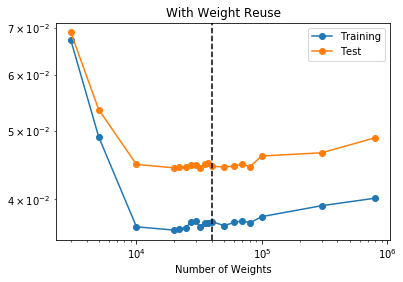

In [67]:
plt.plot(parameter_size, training_df.mean(axis=1), label="Training", marker="o")
plt.plot(parameter_size, test_df.mean(axis=1), label="Test", marker="o")
plt.yscale(value="log")
plt.legend()
plt.xscale(value="log")
x_lbl = plt.xlabel("Number of Weights")
#y_lbl = plt.ylabel("Squared Loss")
plt.xlim(xmin=0)
plt.axvline(x=40000, linestyle="--", color = "black")
plt.title("With Weight Reuse")
plt.savefig("with_reuse.png",bbox_extra_artists=[x_lbl],dpi=500)

## Without Weight Reuse Scheme

In [68]:
train_scores_df = pd.DataFrame()
test_scores_df = pd.DataFrame()

In [69]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()
for run in range(1,6):
    training_loss = []
    test_loss = []
    training_dict  = {}
    test_dict  = {}
    for parameters in parameter_size:
        train_loss = tf.keras.losses.MeanSquaredError(name = "train_loss")
        sgd_optimizer = tf.keras.optimizers.SGD(momentum=0.95)
        #Gives number of units from number of weights
        units = tl.get_number_units(parameters, input_size = input_size, output_size = num_classes)
        network = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(units=units, activation = None),
        tf.keras.layers.Dense(units=num_classes,  activation = None)])
        #Training
        network.compile(optimizer = sgd_optimizer, loss = train_loss , metrics = ['accuracy'])
        print("Fitting Parameter:{}, RUN:{}".format(parameters,run))
        if units < interpol_threshold:
            history = network.fit(x=x_train, y=y_train, callbacks=[earlystop_callback,lr_schedule], epochs=total_epochs, verbose = 0)
        else:
            history = network.fit(x=x_train, y=y_train, epochs=total_epochs, verbose = 0)
        training_loss.append(history.history["loss"][-1])
        print("Testing Parameter:{}, RUN:{}".format(parameters,run))
        results = network.evaluate(x_test, y_test)
        test_loss.append(results[0])
        print("Completed Parameter:{}, RUN:{}".format(parameters,run))
    training_df[str(run)] = training_loss
    test_df[str(run)] = test_loss

Fitting Parameter:3000, RUN:1
Testing Parameter:3000, RUN:1
10000/10000 [==============================] - 1s 108us/sample - loss: 0.0693 - accuracy: 0.5013
Completed Parameter:3000, RUN:1
Fitting Parameter:5000, RUN:1
Testing Parameter:5000, RUN:1
10000/10000 [==============================] - 1s 108us/sample - loss: 0.0533 - accuracy: 0.7179
Completed Parameter:5000, RUN:1
Fitting Parameter:10000, RUN:1
Testing Parameter:10000, RUN:1
10000/10000 [==============================] - 1s 109us/sample - loss: 0.0432 - accuracy: 0.8490
Completed Parameter:10000, RUN:1
Fitting Parameter:20000, RUN:1
Testing Parameter:20000, RUN:1
10000/10000 [==============================] - 1s 110us/sample - loss: 0.0438 - accuracy: 0.8332
Completed Parameter:20000, RUN:1
Fitting Parameter:22000, RUN:1
Testing Parameter:22000, RUN:1
10000/10000 [==============================] - 1s 111us/sample - loss: 0.0444 - accuracy: 0.8281
Completed Parameter:22000, RUN:1
Fitting Parameter:25000, RUN:1
Testing Paramet

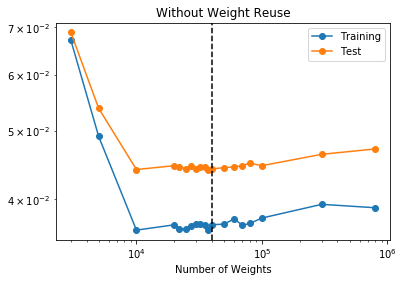

In [71]:
plt.plot(parameter_size, training_df.mean(axis=1), label="Training", marker="o")
plt.plot(parameter_size, test_df.mean(axis=1), label="Test", marker="o")
plt.yscale(value="log")
plt.legend()
plt.xscale(value="log")
x_lbl = plt.xlabel("Number of Weights")
#y_lbl = plt.ylabel("Squared Loss")
plt.xlim(xmin=0)
plt.axvline(x=40000, linestyle="--", color = "black")
plt.title("Without Weight Reuse")
plt.savefig("without_reuse.png",bbox_extra_artists=[y_lbl,x_lbl], dpi=500)